<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/birddet_baseline3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function

In [21]:
# DCASE 2018 - Bird Audio Detection challenge (Task 3)

# This code is a basic implementation of bird audio detector (based on baseline code's architecture)
%cd '/content/drive/My Drive/ukybirddet'
import h5py
import csv
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from HTK import HTKFile

from sklearn.metrics import roc_auc_score, roc_curve, auc

import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, AveragePooling2D
from keras.models import Sequential, load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy, mean_squared_error, mean_absolute_error
from keras.regularizers import l2

import my_callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping




/content/drive/My Drive/ukybirddet


In [0]:
################################################
#
#   Global parameters
#
################################################

#checking mfc features
SPECTPATH = 'workingfiles/features_baseline/'
LABELPATH = 'labels/'
FILELIST = 'workingfiles/filelists/'

RESULTPATH = 'trained_model/baseline/'
SUBMISSIONFILE = 'DCASE_submission_baseline_all.csv'
PREDICTIONPATH = 'prediction/'
dataset = ['BirdVox-DCASE-20k.csv', 'ff1010bird.csv', 'warblrb10k.csv']

logfile_name = RESULTPATH + '40ep_logfile.log'
checkpoint_model_name = RESULTPATH + '40ep_ckpt.h5'
final_model_name = RESULTPATH + '_60ep_flmdl.h5'

BATCH_SIZE = 16
EPOCH_SIZE = 20   ## CHANGED HANIA
AUGMENT_SIZE = 1
with_augmentation = False
domain_adaptation = False
features='h5'
model_operation = 'new'
# model_operations : 'new', 'load', 'test'
shape = (700, 80)
expected_shape = (700, 80)
spect = np.zeros(shape)
label = np.zeros(1)
transform_for_birdvox = np.zeros((80,80))
transform_for_ff1010bird = np.zeros((80,80))
transform_for_chern = np.zeros((80,80))
transform_for_poland = np.zeros((80,80))

# Callbacks for logging during epochs
reduceLR = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
checkPoint = ModelCheckpoint(filepath = checkpoint_model_name, monitor= 'val_acc', mode = 'max', save_best_only=True)
csvLogger = CSVLogger(logfile_name, separator=',', append=False)

################################################
#
#   Data set selection
#
################################################

# Parameters in this section can be adjusted to select different data sets to train, test, and validate on.

# Keys by which we will access properties of a data set. The values assigned here are ultimately meaningless.
# The 'k' prefix on these declarations signify that they will be used as keys in a dictionary.
k_VAL_FILE = 'validation_file_path'
k_TEST_FILE = 'test_file_path'
k_TRAIN_FILE = 'train_file_path'
k_VAL_SIZE = 'validate_size'
k_TEST_SIZE = 'test_size'
k_TRAIN_SIZE = 'train_size'
k_CLASS_WEIGHT = 'class_weight'
#k_TRANSFORM_MATRIX = 'transform_matrix'
f_TRANSFORM_SRC_BIRDVOX= 'adaptation_files/transform_source_700_BirdVox-DCASE-20k.h5'
f_TRANSFORM_SRC_FF1010BIRD='adaptation_files/transform_source_700_ff1010bird.h5'
f_TRANSFORM_SRC_POLANDNFC='adaptation_files/transform_source_700_PolandNFC.h5'
f_TRANSFORM_SRC_CHERNOBYL='adaptation_files/transform_source_700_Chernobyl.h5'

# Declare the dictionaries to represent the data sets
d_birdVox = {k_VAL_FILE: 'val_B', k_TEST_FILE: 'test_B', k_TRAIN_FILE: 'train_B',
             k_VAL_SIZE: 1000.0, k_TEST_SIZE: 3000.0, k_TRAIN_SIZE: 16000.0,
             k_CLASS_WEIGHT: {0: 0.50,1: 0.50}}
d_warblr = {k_VAL_FILE: 'val_W', k_TEST_FILE: 'test_W', k_TRAIN_FILE: 'train_W',
            k_VAL_SIZE: 400.0, k_TEST_SIZE: 1200.0, k_TRAIN_SIZE: 6400.0,
            k_CLASS_WEIGHT: {0: 0.75, 1: 0.25}}
d_freefield = {k_VAL_FILE: 'val_F', k_TEST_FILE: 'test_F', k_TRAIN_FILE: 'train_F',
               k_VAL_SIZE: 385.0, k_TEST_SIZE: 1153.0, k_TRAIN_SIZE: 6152.0,
               k_CLASS_WEIGHT: {0: 0.25, 1: 0.75}}
d_fold1 = {k_VAL_FILE: 'test_BF', k_TEST_FILE: 'val_1', k_TRAIN_FILE: 'train_BF',
           k_VAL_SIZE: 4153.0, k_TEST_SIZE: 8000.0, k_TRAIN_SIZE: 22152.0,
           k_CLASS_WEIGHT: {0: 0.43, 1: 0.57}}
d_fold2 = {k_VAL_FILE: 'test_WF', k_TEST_FILE: 'val_2', k_TRAIN_FILE: 'train_WF',
           k_VAL_SIZE: 2353.0, k_TEST_SIZE: 20000.0, k_TRAIN_SIZE: 12552.0,
           k_CLASS_WEIGHT: {0: 0.50, 1: 0.50}}
d_fold3 = {k_VAL_FILE: 'test_BW', k_TEST_FILE: 'val_3', k_TRAIN_FILE: 'train_BW',
           k_VAL_SIZE: 4200.0, k_TEST_SIZE: 7690.0, k_TRAIN_SIZE: 22400.0,
           k_CLASS_WEIGHT: {0: 0.57, 1: 0.43}}
d_all3 = {k_VAL_FILE: 'val_BWF', k_TEST_FILE:'test', k_TRAIN_FILE: 'train_BWF',
           k_VAL_SIZE: 1785.0, k_TEST_SIZE: 12620.0, k_TRAIN_SIZE: 35960.0,
           k_CLASS_WEIGHT: {0: 0.50, 1: 0.50}}
d_moj = {k_VAL_FILE: 'val_BWF_moj', k_TEST_FILE:'test_NFC_only', k_TRAIN_FILE: 'train_BWF_moj',
           k_VAL_SIZE: 1785.0, k_TEST_SIZE: 4001.0, k_TRAIN_SIZE: 35960.0,
           k_CLASS_WEIGHT: {0: 0.50, 1: 0.50}}  
# Declare the training, validation, and testing sets here using the dictionaries defined above.
# Set these variables to change the data set.
training_set = d_all3
validation_set = d_all3
test_set = d_moj #d_all3

# Grab the file lists and sizes from the corresponding data sets.
train_filelist = FILELIST + training_set[k_TRAIN_FILE]
TRAIN_SIZE = training_set[k_TRAIN_SIZE]

val_filelist = FILELIST + validation_set[k_VAL_FILE]
VAL_SIZE = validation_set[k_VAL_SIZE]

test_filelist = FILELIST + test_set[k_TEST_FILE]
TEST_SIZE = test_set[k_TEST_SIZE]

################################################
#
#   Generator with Augmentation
#
################################################

# use this generator when augmentation is needed
def data_generator(filelistpath, batch_size=16, shuffle=False):
    batch_index = 0
    image_index = -1
    filelist = open(filelistpath, 'r')
    filenames = filelist.readlines()
    filelist.close()

    # shuffling filelist
    if shuffle==True:
        random.shuffle(filenames)

    dataset = ['BirdVox-DCASE-20k.csv', 'ff1010bird.csv', 'warblrb10k.csv']

    labels_dict = {}
    for n in range(len(dataset)):
        labels_list = csv.reader(open(LABELPATH + dataset[n], 'r'))
        next(labels_list)
        for k, r, v in labels_list:
            labels_dict[r + '/' + k + '.wav'] = v

    while True:
        image_index = (image_index + 1) % len(filenames)

        # if shuffle and image_index = 0
        # shuffling filelist
        if shuffle == True and image_index == 0:
            random.shuffle(filenames)

        file_id = filenames[image_index].rstrip()

        if batch_index == 0:
            # re-initialize spectrogram and label batch
            spect_batch = np.zeros([1, spect.shape[0], spect.shape[1], 1])
            label_batch = np.zeros([1, 1])
            aug_spect_batch = np.zeros([batch_size, spect.shape[0], spect.shape[1], 1])
            aug_label_batch = np.zeros([batch_size, 1])

        if features=='h5':
            hf = h5py.File(SPECTPATH + file_id + '.h5', 'r')
            imagedata = hf.get('features')
            imagedata = np.array(imagedata)
            hf.close()
            # normalizing intensity values of spectrogram from [-15.0966 to 2.25745] to [0 to 1] range
            imagedata = (imagedata + 15.0966)/(15.0966 + 2.25745)
        elif features == 'mfc':
            htk_reader = HTKFile()
            htk_reader.load(SPECTPATH + file_id[:-4] + '.mfc')
            imagedata = np.array(htk_reader.data)
            imagedata = imagedata / 17.0

        # processing files with shapes other than expected shape in warblr dataset

        if imagedata.shape[0] != expected_shape[0]:
            old_imagedata = imagedata
            imagedata = np.zeros(expected_shape)

            if old_imagedata.shape[0] < expected_shape[0]:

                diff_in_frames = expected_shape[0] - old_imagedata.shape[0]
                if diff_in_frames < expected_shape[0] / 2:
                    imagedata = np.vstack((old_imagedata, old_imagedata[
                        range(old_imagedata.shape[0] - diff_in_frames, old_imagedata.shape[0])]))

                elif diff_in_frames > expected_shape[0] / 2:
                    count = np.floor(expected_shape[0] / old_imagedata.shape[0])
                    remaining_diff = (expected_shape[0] - old_imagedata.shape[0] * int(count))
                    imagedata = np.vstack(([old_imagedata] * int(count)))
                    imagedata = np.vstack(
                        (imagedata, old_imagedata[range(old_imagedata.shape[0] - remaining_diff, old_imagedata.shape[0])]))

            elif old_imagedata.shape[0] > expected_shape[0]:
                diff_in_frames = old_imagedata.shape[0] - expected_shape[0]

                if diff_in_frames < expected_shape[0] / 2:
                    imagedata[range(0, diff_in_frames + 1), :] = np.mean(np.array([old_imagedata[range(0, diff_in_frames + 1), :],old_imagedata[range(old_imagedata.shape[0] - diff_in_frames - 1, old_imagedata.shape[0]), :]]),axis=0)
                    imagedata[range(diff_in_frames + 1, expected_shape[0]), :] = old_imagedata[range(diff_in_frames + 1, expected_shape[0])]

                elif diff_in_frames > expected_shape[0] / 2:
                    count = int(np.floor(old_imagedata.shape[0] / expected_shape[0]))
                    remaining_diff = (old_imagedata.shape[0] - expected_shape[0] * count)
                    for index in range(0, count):
                        imagedata[range(0, expected_shape[0]), :] = np.sum([imagedata, old_imagedata[range(index * expected_shape[0], (index + 1) * expected_shape[0])]],axis=0) / count
                        imagedata[range(0, remaining_diff), :] = np.mean(np.array([old_imagedata[range(old_imagedata.shape[0] - remaining_diff, old_imagedata.shape[0]), :],imagedata[range(0, remaining_diff), :]]), axis=0)


        imagedata = np.reshape(imagedata, (1, imagedata.shape[0], imagedata.shape[1], 1))

        spect_batch[0, :, :, :] = imagedata
        label_batch[0, :] = labels_dict[file_id]

        gen_img = datagen.flow(imagedata, label_batch[0, :], batch_size=1, shuffle=False, save_to_dir=None)
        aug_spect_batch[batch_index, :, :, :] = imagedata
        aug_label_batch[batch_index, :] = label_batch[0, :]
        batch_index += 1

        for n in range(AUGMENT_SIZE-1):
            aug_spect_batch[batch_index, :, :, :], aug_label_batch[batch_index, :] = gen_img.next()
            batch_index += 1
            if batch_index >= batch_size:
                batch_index = 0
                inputs = [aug_spect_batch]
                outputs = [aug_label_batch]
                yield inputs, outputs


################################################
#
#   Generator without Augmentation
#
################################################

def dataval_generator(filelistpath, batch_size=32, shuffle=False):
    batch_index = 0
    image_index = -1

    filelist = open(filelistpath, 'r')
    filenames = filelist.readlines()
    filelist.close()

    dataset = (['PolandNFC.csv'])#dataset = (['Chernobyl.csv', 'PolandNFC.csv', 'warblrb10k-eval.csv'])

    labels_dict = {}
    for n in range(len(dataset)):
        labels_list = csv.reader(open(LABELPATH + dataset[n], 'r'))
        next(labels_list)
        for k, r, v in labels_list:
            labels_dict[r + '/' + k + '.wav'] = v

    while True:
        image_index = (image_index + 1) % len(filenames)

        # if shuffle and image_index = 0
        # shuffling filelist
        if shuffle == True and image_index == 0:
            random.shuffle(filenames)

        file_id = filenames[image_index].rstrip()

        if batch_index == 0:
            # re-initialize spectrogram and label batch
            spect_batch = np.zeros([batch_size, spect.shape[0], spect.shape[1], 1])
            label_batch = np.zeros([batch_size, 1])

        if features == 'h5':
            #file_prefix = file_id[:file_id.rfind("/")+1]
            #file_suffix = file_id[file_id.rfind("/")+1:]
            #hf = h5py.File(SPECTPATH + file_prefix + 'enhanced_'+ file_suffix + '.h5')
            hf = h5py.File(SPECTPATH + file_id + '.h5', 'r')#[:-4]for evaluation dataset
            imagedata = hf.get('features')
            imagedata = np.array(imagedata)
            hf.close()

            # normalizing intensity values of spectrogram from [-15.0966 to 2.25745] to [0 to 1] range
            imagedata = (imagedata + 15.0966)/(15.0966 + 2.25745)

        elif features == 'mfc':
            htk_reader = HTKFile()
            #file_prefix = file_id[:file_id.rfind("/")+1]
            #file_suffix = file_id[file_id.rfind("/")+1:]
            #htk_reader.load(SPECTPATH + file_prefix + 'enhanced_'+ file_suffix[:-4] + '.mfc')
            htk_reader.load(SPECTPATH + file_id[:-4] + '.mfc')
            imagedata = np.array(htk_reader.data)
            imagedata = imagedata/17.0

        # processing files with shapes other than expected shape in warblr dataset

        if imagedata.shape[0] != expected_shape[0]:
            old_imagedata = imagedata
            imagedata = np.zeros(expected_shape)

            if old_imagedata.shape[0] < expected_shape[0]:

                diff_in_frames = expected_shape[0] - old_imagedata.shape[0]
                if diff_in_frames < expected_shape[0] / 2:
                    imagedata = np.vstack((old_imagedata, old_imagedata[
                        range(old_imagedata.shape[0] - diff_in_frames, old_imagedata.shape[0])]))

                elif diff_in_frames > expected_shape[0] / 2:
                    count = np.floor(expected_shape[0] / old_imagedata.shape[0])
                    remaining_diff = (expected_shape[0] - old_imagedata.shape[0] * int(count))
                    imagedata = np.vstack(([old_imagedata] * int(count)))
                    imagedata = np.vstack(
                        (imagedata, old_imagedata[range(old_imagedata.shape[0] - remaining_diff, old_imagedata.shape[0])]))

            elif old_imagedata.shape[0] > expected_shape[0]:
                diff_in_frames = old_imagedata.shape[0] - expected_shape[0]

                if diff_in_frames < expected_shape[0] / 2:
                    imagedata[range(0, diff_in_frames + 1), :] = np.mean(np.array([old_imagedata[range(0, diff_in_frames + 1), :],old_imagedata[range(old_imagedata.shape[0] - diff_in_frames - 1, old_imagedata.shape[0]), :]]),axis=0)
                    imagedata[range(diff_in_frames + 1, expected_shape[0]), :] = old_imagedata[range(diff_in_frames + 1, expected_shape[0])]

                elif diff_in_frames > expected_shape[0] / 2:
                    count = int(np.floor(old_imagedata.shape[0] / expected_shape[0]))
                    remaining_diff = (old_imagedata.shape[0] - expected_shape[0] * count)
                    for index in range(0, count):
                        imagedata[range(0, expected_shape[0]), :] = np.sum([imagedata, old_imagedata[range(index * expected_shape[0], (index + 1) * expected_shape[0])]],axis=0) / count
                        imagedata[range(0, remaining_diff), :] = np.mean(np.array([old_imagedata[range(old_imagedata.shape[0] - remaining_diff, old_imagedata.shape[0]), :],imagedata[range(0, remaining_diff), :]]), axis=0)

        if domain_adaptation == True:
            filedataset = file_id[:file_id.rfind('/')]
            #print('Domain adaptation is supposed to be off')
            if filedataset == 'BirdVox-DCASE-20k':
                imagedata = np.matmul(imagedata, transform_for_birdvox)
                imagedata = (imagedata - 3.4) / (6.95 - 3.4)
                #min: 3.4020782 - -max:6.9419036

            elif filedataset == 'ff1010bird':
                imagedata = np.matmul(imagedata, transform_for_ff1010bird)
                imagedata = (imagedata - 1.4) / (7.37 - 1.4)
                # min:1.4374458--max:7.363845

            elif filedataset == 'Chernobyl':
                imagedata = np.matmul(imagedata, transform_for_chern)
                imagedata = (imagedata - 3.75) / (7 - 3.75)
                #3.7511292--max:7.00125

            elif filedataset == 'PolandNFC':
                imagedata = np.matmul(imagedata, transform_for_poland)
                imagedata = (imagedata + 10.8) / (10.8 + 7.40)
                # -10.796116--max:7.4045897
        imagedata = np.reshape(imagedata, (1, imagedata.shape[0], imagedata.shape[1], 1))

        spect_batch[batch_index, :, :, :] = imagedata
        if model_operation != 'test':
            label_batch[batch_index, :] = labels_dict[file_id]

        batch_index += 1

        if batch_index >= batch_size:
            batch_index = 0
            inputs = [spect_batch]
            outputs = [label_batch]
            yield inputs, outputs

def datatest_generator(filelistpath, batch_size=32, shuffle=False):
    batch_index = 0
    image_index = -1

    filelist = open(filelistpath, 'r')
    filenames = filelist.readlines()
    filelist.close()

    dataset = (['PolandNEW.csv'])#(['Chernobyl.csv', 'PolandNFC.csv', 'warblrb10k-eval.csv'])

    labels_dict = {}
    for n in range(len(dataset)):
        labels_list = csv.reader(open(LABELPATH + dataset[n], 'r'))
        next(labels_list)
        for k, r, v in labels_list:
            labels_dict[r + '/' + k] = v

    while True:
        image_index = (image_index + 1) % len(filenames)

        # if shuffle and image_index = 0
        # shuffling filelist
        if shuffle == True and image_index == 0:
            random.shuffle(filenames)

        file_id = filenames[image_index].rstrip()

        if batch_index == 0:
            # re-initialize spectrogram and label batch
            spect_batch = np.zeros([batch_size, spect.shape[0], spect.shape[1], 1])
            label_batch = np.zeros([batch_size, 1])

        if features == 'h5':
            #file_prefix = file_id[:file_id.rfind("/")+1]
            #file_suffix = file_id[file_id.rfind("/")+1:]
            #hf = h5py.File(SPECTPATH + file_prefix + 'enhanced_'+ file_suffix + '.h5')
            hf = h5py.File(SPECTPATH + file_id[:-4] + '.h5', 'r')#[:-4]for evaluation dataset
            imagedata = hf.get('features')
            imagedata = np.array(imagedata)
            hf.close()

            # normalizing intensity values of spectrogram from [-15.0966 to 2.25745] to [0 to 1] range
            imagedata = (imagedata + 15.0966)/(15.0966 + 2.25745)

        elif features == 'mfc':
            htk_reader = HTKFile()
            #file_prefix = file_id[:file_id.rfind("/")+1]
            #file_suffix = file_id[file_id.rfind("/")+1:]
            #htk_reader.load(SPECTPATH + file_prefix + 'enhanced_'+ file_suffix[:-4] + '.mfc')
            htk_reader.load(SPECTPATH + file_id[:-8] + '.mfc')
            imagedata = np.array(htk_reader.data)
            imagedata = imagedata/17.0

        # processing files with shapes other than expected shape in warblr dataset

        if imagedata.shape[0] != expected_shape[0]:
            old_imagedata = imagedata
            imagedata = np.zeros(expected_shape)

            if old_imagedata.shape[0] < expected_shape[0]:

                diff_in_frames = expected_shape[0] - old_imagedata.shape[0]
                if diff_in_frames < expected_shape[0] / 2:
                    imagedata = np.vstack((old_imagedata, old_imagedata[
                        range(old_imagedata.shape[0] - diff_in_frames, old_imagedata.shape[0])]))

                elif diff_in_frames > expected_shape[0] / 2:
                    count = np.floor(expected_shape[0] / old_imagedata.shape[0])
                    remaining_diff = (expected_shape[0] - old_imagedata.shape[0] * int(count))
                    imagedata = np.vstack(([old_imagedata] * int(count)))
                    imagedata = np.vstack(
                        (imagedata, old_imagedata[range(old_imagedata.shape[0] - remaining_diff, old_imagedata.shape[0])]))

            elif old_imagedata.shape[0] > expected_shape[0]:
                diff_in_frames = old_imagedata.shape[0] - expected_shape[0]

                if diff_in_frames < expected_shape[0] / 2:
                    imagedata[range(0, diff_in_frames + 1), :] = np.mean(np.array([old_imagedata[range(0, diff_in_frames + 1), :],old_imagedata[range(old_imagedata.shape[0] - diff_in_frames - 1, old_imagedata.shape[0]), :]]),axis=0)
                    imagedata[range(diff_in_frames + 1, expected_shape[0]), :] = old_imagedata[range(diff_in_frames + 1, expected_shape[0])]

                elif diff_in_frames > expected_shape[0] / 2:
                    count = int(np.floor(old_imagedata.shape[0] / expected_shape[0]))
                    remaining_diff = (old_imagedata.shape[0] - expected_shape[0] * count)
                    for index in range(0, count):
                        imagedata[range(0, expected_shape[0]), :] = np.sum([imagedata, old_imagedata[range(index * expected_shape[0], (index + 1) * expected_shape[0])]],axis=0) / count
                        imagedata[range(0, remaining_diff), :] = np.mean(np.array([old_imagedata[range(old_imagedata.shape[0] - remaining_diff, old_imagedata.shape[0]), :],imagedata[range(0, remaining_diff), :]]), axis=0)

        if domain_adaptation == True:
            filedataset = file_id[:file_id.rfind('/')]
            #print('Domain adaptation is supposed to be off')
            if filedataset == 'BirdVox-DCASE-20k':
                imagedata = np.matmul(imagedata, transform_for_birdvox)
                imagedata = (imagedata - 3.4) / (6.95 - 3.4)
                #min: 3.4020782 - -max:6.9419036

            elif filedataset == 'ff1010bird':
                imagedata = np.matmul(imagedata, transform_for_ff1010bird)
                imagedata = (imagedata - 1.4) / (7.37 - 1.4)
                # min:1.4374458--max:7.363845

            elif filedataset == 'Chernobyl':
                imagedata = np.matmul(imagedata, transform_for_chern)
                imagedata = (imagedata - 3.75) / (7 - 3.75)
                #3.7511292--max:7.00125

            elif filedataset == 'PolandNFC':
                imagedata = np.matmul(imagedata, transform_for_poland)
                imagedata = (imagedata + 10.8) / (10.8 + 7.40)
                # -10.796116--max:7.4045897
        imagedata = np.reshape(imagedata, (1, imagedata.shape[0], imagedata.shape[1], 1))

        spect_batch[batch_index, :, :, :] = imagedata

        batch_index += 1

        if batch_index >= batch_size:
            batch_index = 0
            inputs = [spect_batch]
            yield inputs


In [0]:
################################################
#
#   ROC Label Generation
#
################################################

def testdata(filelistpath, test_size):
    image_index = -1

    filelist = open(filelistpath, 'r')
    filenames = filelist.readlines()
    filelist.close()

    #dataset = (['Chernobyl.csv', 'PolandNFC.csv', 'warblrb10k-eval.csv'])

    labels_dict = {}
    for n in range(len(dataset)):
        labels_list = csv.reader(open(LABELPATH + dataset[n], 'r'))
        next(labels_list)
        for k, r, v in labels_list:
            labels_dict[r + '/' + k + '.wav'] = v

    label_batch = np.zeros([int(test_size), 1])

    for m in range(len(filenames)):
        image_index = (image_index + 1) % len(filenames)

        file_id = filenames[image_index].rstrip()

        label_batch[image_index, :] = labels_dict[file_id]

        outputs = [label_batch]

    return outputs

################################################
#
#   Reading covariance transforms
#
################################################

#reading birdvox transform
htf = h5py.File(f_TRANSFORM_SRC_BIRDVOX, 'r')
transform_for_birdvox = htf.get('cov')
transform_for_birdvox = np.array(transform_for_birdvox)
htf.close()

#reading ff1010bird transform
htf = h5py.File(f_TRANSFORM_SRC_FF1010BIRD, 'r')
transform_for_ff1010bird = htf.get('cov')
transform_for_ff1010bird = np.array(transform_for_ff1010bird)
htf.close()

#reading chernobyl transform
htf = h5py.File(f_TRANSFORM_SRC_CHERNOBYL, 'r')
transform_for_chern = htf.get('cov')
transform_for_chern = np.array(transform_for_chern)
htf.close()

#reading polandnfc transform
htf = h5py.File(f_TRANSFORM_SRC_POLANDNFC, 'r')
transform_for_poland = htf.get('cov')
transform_for_poland = np.array(transform_for_poland)
htf.close()

#reading polandnew transform
htf = h5py.File(f_TRANSFORM_SRC_POLANDNEW, 'r')
transform_for_poland_new = htf.get('cov')
transform_for_poland_new = np.array(transform_for_poland_new)
htf.close()


if(with_augmentation == True):
    train_generator = data_generator(train_filelist, BATCH_SIZE, True)
else:
    train_generator = dataval_generator(train_filelist, BATCH_SIZE, True)

validation_generator = dataval_generator(val_filelist, BATCH_SIZE, False)
test_generator = datatest_generator(test_filelist, BATCH_SIZE, False)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0,
    width_shift_range=0.05,
    height_shift_range=0.9,
    horizontal_flip=False,
    fill_mode="wrap")

################################################
#
#   Model Creation
#
################################################
if model_operation == 'new':
    model = Sequential()
    # augmentation generator
    # code from baseline : "augment:Rotation|augment:Shift(low=-1,high=1,axis=3)"
    # keras augmentation:
    #preprocessing_function

    # convolution layers
    model.add(Conv2D(16, (3, 3), padding='valid', input_shape=(700, 80, 1), ))  # low: try different kernel_initializer
    model.add(BatchNormalization())  # explore order of Batchnorm and activation
    model.add(LeakyReLU(alpha=.001))
    model.add(MaxPooling2D(pool_size=(3, 3)))  # experiment with using smaller pooling along frequency axis
    model.add(Conv2D(16, (3, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(16, (3, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))
    model.add(MaxPooling2D(pool_size=(3, 1)))
    model.add(Conv2D(16, (3, 3), padding='valid', kernel_regularizer=l2(0.01)))  # drfault 0.01. Try 0.001 and 0.001
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))
    model.add(MaxPooling2D(pool_size=(3, 1)))

    # dense layers
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))  # leaky relu value is very small experiment with bigger ones
    model.add(Dropout(0.5))  # experiment with removing this dropout
    model.add(Dense(1, activation='sigmoid'))

elif model_operation == 'load' or model_operation == 'test':
    model = load_model(RESULTPATH + 'flmdl.h5')

if model_operation == 'new' or model_operation == 'load':
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

    # prepare callback
    histories = my_callbacks.Histories()

model.summary()

my_steps = np.floor(TRAIN_SIZE*AUGMENT_SIZE / BATCH_SIZE)
my_val_steps = np.floor(VAL_SIZE / BATCH_SIZE)
my_test_steps = np.ceil(TEST_SIZE / BATCH_SIZE)

if model_operation == 'new' or model_operation == 'load':
    model = load_model("/content/drive/My Drive/ukybirddet/trained_model/baseline/_40ep_flmdl.h5")                        ## HANIA  CHANGED
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=my_steps,
        epochs=EPOCH_SIZE,
        validation_data=validation_generator,
        validation_steps=my_val_steps,
        callbacks= [checkPoint, reduceLR, csvLogger],
        class_weight= training_set[k_CLASS_WEIGHT],
        verbose=True)

    #model.save(final_model_name)  ## CHANGED HANIA
    print('Training done. The results are in : '+RESULTPATH)

# generating prediction values for computing ROC_AUC score
# whether model_operation is 'new', 'load' or 'test'

pred_generator = datatest_generator(test_filelist, BATCH_SIZE, False)
y_pred = model.predict_generator(
    pred_generator,
    steps=my_test_steps)
print(y_pred)

# saving predictions in csv file

testfile = open(test_filelist, 'r')
testfilenames = testfile.readlines()
testfile.close()

fidwr = open(PREDICTIONPATH+SUBMISSIONFILE, 'wt')
try:
    writer = csv.writer(fidwr)
    for i in range(len(testfilenames)):
        strf = testfilenames[i]
        writer.writerow((strf[strf.find('/')+1:-9], str(float(y_pred[i]))))
finally:
    fidwr.close()

In [293]:
print(test_filelist)


workingfiles/filelists/test_NFC_only


In [294]:
from keras.models import Sequential, load_model
my_test_steps = np.ceil(TEST_SIZE / BATCH_SIZE)
#test_filelist = 'workingfiles/filelists/test'

model = load_model("/content/drive/My Drive/ukybirddet/trained_model/baseline/_60ep_flmdl.h5")
pred_generator = datatest_generator(test_filelist, BATCH_SIZE, False)
print(my_test_steps)
print(pred_generator)

251.0
<generator object datatest_generator at 0x7f02c2060bf8>


In [297]:

y_pred = model.predict_generator(
    pred_generator,
    steps=my_test_steps)
print(y_pred)


testfile = open(test_filelist, 'r')
testfilenames = testfile.readlines()
testfile.close()

#SUBMISSIONFILE = 'DCASE_submission_baseline_all_20e.csv'
#PREDICTIONPATH = 'prediction/'

fidwr = open(PREDICTIONPATH+'aaa'+SUBMISSIONFILE, 'wt')
try:
    writer = csv.writer(fidwr)
    for i in range(len(testfilenames)):
        strf = testfilenames[i]
        writer.writerow((strf[strf.find('/')+1:-9], str(float(y_pred[i]))))
finally:
    fidwr.close()


[[0.36194098]
 [0.22364289]
 [0.26208457]
 ...
 [0.6095043 ]
 [0.20555836]
 [0.29612002]]


In [296]:
i = 4000
y_pred[i]
print(str(float(y_pred[i])))
print(testfilenames[i])
strf = testfilenames[i]
print((strf[strf.find('/')+1:-9]))

0.18056577444076538


IndexError: ignored

In [0]:
from sklearn.metrics import roc_auc_score
import pandas as pd
def readcsv(filename):
    data = pd.read_csv(filename,header=None) 
    return(np.array(data)) 

In [0]:
## dla plików w csv tak samo poukładanych

y_score = readcsv(PREDICTIONPATH+SUBMISSIONFILE)
y_true = readcsv(PREDICTIONPATH+'real_'+ORIG)
#print(np.shape(y_true[:,1])) #print(np.shape(y_score[:,1]))

y_trues = y_true[:,1].astype(float)#np.array([0, 0, 1, 1]) #aaa = y_trues.astype(int) #y_trues2 =np.array([0,1,0,0])
print(y_trues)
y_scores = y_score[:,1]#np.array([0.1, 0.4, 0.35, 0.8])  #y_scores2 =np.array(y_score[0:4,1])
print((y_scores))

roc_auc_score(y_trues,y_scores)


8000
[['BUK5_20170923_025405_5' 0.2158494591712952]
 ['BUK5_20170923_025405_6' 0.660135805606842]
 ['BUK5_20170923_025405_7' 0.21109360456466675]
 ['BUK5_20170923_025405_8' 0.2128499448299408]
 ['BUK5_20170923_025405_9' 0.1952957808971405]]
8002
[['BUK5_20170923_025405_5' '1']
 ['BUK5_20170923_025405_6' '1']
 ['BUK5_20170923_025405_7' '0']
 ['BUK5_20170923_025405_8' '0']
 ['BUK5_20170923_025405_9' '0']]


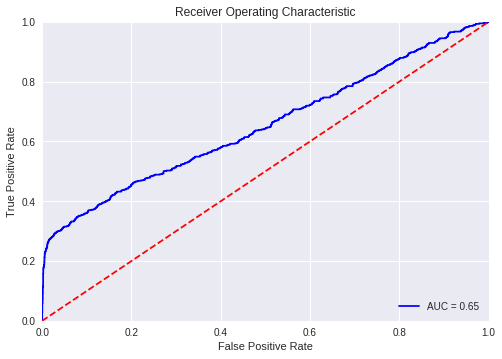

In [351]:
## dla plików w csv inaczej samo poukładanych - sortowanie
ORIG = 'DCASE_submission_baseline_all.csv'
SUBMISSIONFILE = 'DCASE_submission_baseline_all.csv'
PREDICTIONPATH = 'prediction/'


y_score = readcsv(PREDICTIONPATH+SUBMISSIONFILE)
y_true = readcsv(PREDICTIONPATH+'real_'+ORIG)

#out = y_score[np.argsort(y_score[0:10, 0])[::-1]]
#print(out)
a = 1996
y_score_out = y_score[y_score[0:4000,0].astype(str).argsort()]
print(np.size(y_score_out))
print((y_score_out[3995:4000]))

y_true_out = y_true[y_true[:,0].astype(str).argsort()]
print(np.size(y_true_out))
print((y_true_out[3995:4000,:]))

roc_auc_score(y_true_out[0:4000,1].astype(float),y_score_out[:,1])

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
y_trues = y_true_out[0:4000,1].astype(float)
y_probas = y_score_out[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_probas)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()